# Model Training

## Imports

In [1]:
import pandas as pd
import numpy as np
from src.__00__paths import curated_data_dir, figures_dir, model_dir, docs_dir
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import pandas as pd

import matplotlib.pyplot as plt
import joblib

## Load Dataframe

In [2]:
test_df = pd.read_csv(curated_data_dir / "test.csv")
test_df.head()

,Type_A,Type_B,Type_C,Size,Dept,IsHoliday,time_index,woy_sin,woy_cos,mon_sin,...,dist_easter_wk,dist_memorial_day_wk,dist_july4_wk,dist_labor_day_wk,dist_super_bowl_wk,is_black_friday_wk,is_thanksgiving_wk,is_xmas_peak_wk,is_back_to_school,Weekly_Sales
0,False,True,False,125833,17,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,4202.98
1,True,False,False,184109,41,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,307.50
2,True,False,False,203750,3,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,7245.43
3,False,False,True,39910,23,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,23.01
4,False,True,False,140167,4,False,115,0.937328,-0.348448,0.866025,...,1,-6,0,0,0,1,1,1,0,19455.41


In [3]:
train_df = pd.read_csv(curated_data_dir / "train.csv")
train_df.head()

,Type_A,Type_B,Type_C,Size,Dept,IsHoliday,time_index,woy_sin,woy_cos,mon_sin,...,dist_easter_wk,dist_memorial_day_wk,dist_july4_wk,dist_labor_day_wk,dist_super_bowl_wk,is_black_friday_wk,is_thanksgiving_wk,is_xmas_peak_wk,is_back_to_school,Weekly_Sales
0,True,False,False,151315,1,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,24924.50
1,False,True,False,125833,97,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,668.48
2,False,True,False,125833,85,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,693.87
3,True,False,False,155078,80,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,8654.60
4,False,True,False,125833,55,False,0,0.566372,0.82415,0.866025,...,0,0,0,0,-1,1,1,1,0,11123.56


## Split Features & Labels

In [4]:
x_train = train_df.drop(columns=["Weekly_Sales"])
y_train = train_df["Weekly_Sales"]

## Hyperparameter Tuning & Model Training

In [ ]:
rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)

param_dist = {
    'n_estimators': randint(100, 250),  # fewer trees → smaller file
    'max_depth': randint(12, 26),  # cap depth to tame size
    'min_samples_split': randint(2, 12),
    'min_samples_leaf': randint(1, 6),
    'max_features': ['sqrt', 'log2', 1.0],  # avoid 'auto'
    'max_samples': uniform(0.7, 0.3),  # each tree sees 70–100% of rows
}

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_rf = random_search.best_estimator_  # already fitted
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END max_depth=18, max_features=sqrt, max_samples=0.7550304369598491, min_samples_leaf=5, min_samples_split=6, n_estimators=202; total time=  26.3s
[CV] END max_depth=18, max_features=sqrt, max_samples=0.7550304369598491, min_samples_leaf=5, min_samples_split=6, n_estimators=202; total time=  26.9s
[CV] END max_depth=18, max_features=sqrt, max_samples=0.7550304369598491, min_samples_leaf=5, min_samples_split=6, n_estimators=202; total time=  27.2s


## Save the Model

In [17]:
model_path = model_dir / "random_forest_model.joblib"
joblib.dump(best_rf, model_path, compress=3)  # compress=3 is a good trade-off

rel_path = "/".join(model_path.parts[-3:])
print(f"Model saved to {rel_path}")

Model saved to outputs/models/random_forest_model.joblib


## Save Hyperparameter Tuning

In [18]:
## Save Hyperparameter Tuning
params_file = docs_dir / "RF_model_params.txt"
params = random_search.best_params_

with open(params_file, "w") as f:
    f.write("Model Hyperparameters:\n")
    for key, value in params.items():
        f.write(f"- {key:<18}: {value}\n")

# also log model size
model_size_mb = model_path.stat().st_size / (1024 ** 2)
print(f"Parameters saved to: {'/'.join(params_file.parts[-3:])}")
print(f"Model size: {model_size_mb:.2f} MB")

Parameters saved to: outputs/docs/RF_model_params.txt


## Visualization

### Top 20 Features

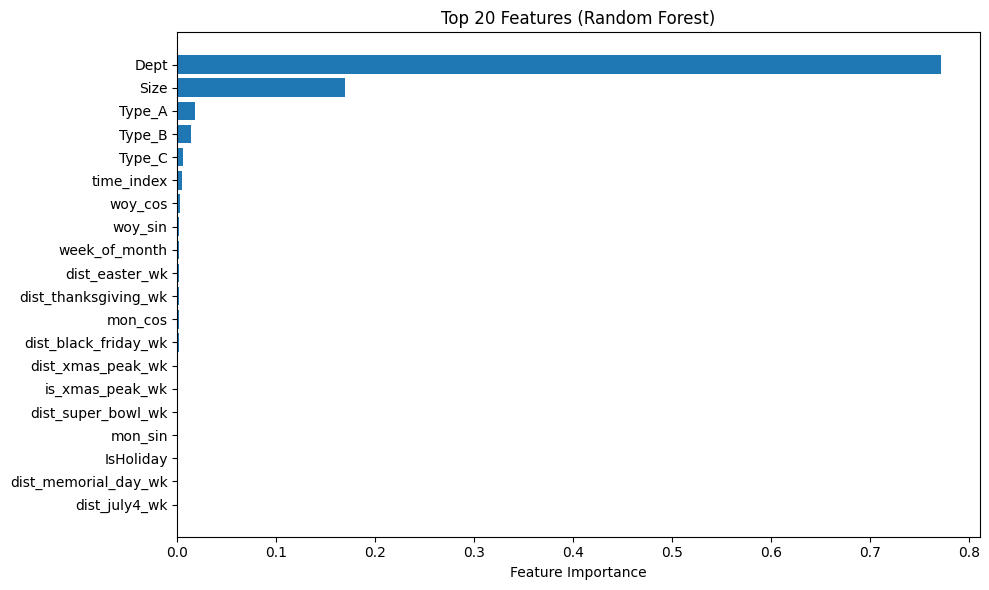

In [19]:
importances = best_rf.feature_importances_
features = x_train.columns
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), features[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features (Random Forest)")
plt.tight_layout()

# Save the figure before showing it
plt.savefig(figures_dir / "RF_feature_importance.png", dpi=300)

plt.show()

### Tree Visualization

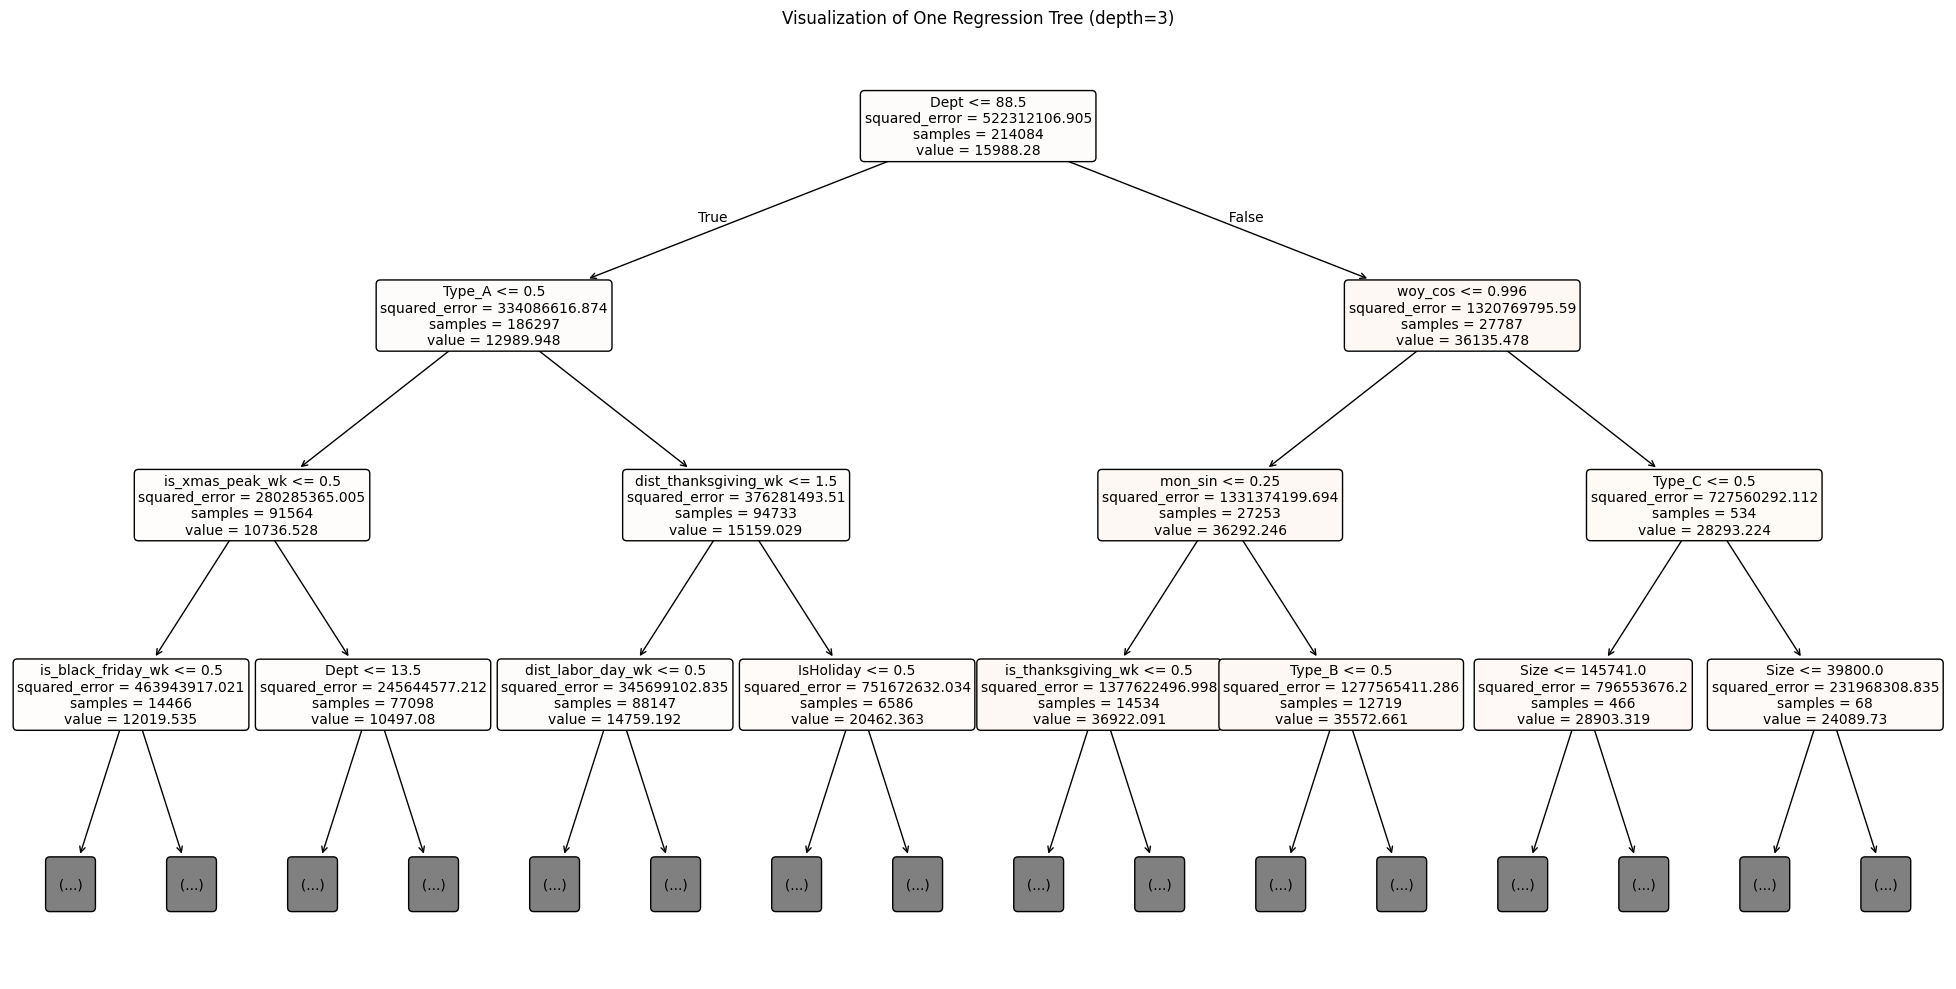

In [20]:
# Choose a tree from the forest (e.g., the 0th one)
estimator = best_rf.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    feature_names=x_train.columns,
    filled=True,
    rounded=True,
    max_depth=3,  # limit to 3 levels to make it readable
    fontsize=10
)
plt.title("Visualization of One Regression Tree (depth=3)")
plt.tight_layout()
plt.savefig(figures_dir / "RF_tree_visualization.png", dpi=300)
plt.show()